In [10]:
import numpy as np
import pygad
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd

In [11]:
# Step 1: Data Preparation
# Fetch real historical data from Yahoo Finance
num_assets = 5
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Download the adjusted closing prices for the selected tickers
data = yf.download(tickers, start="2018-01-01", end="2024-01-01")['Adj Close']

# Drop tickers that failed to download
data = data.dropna(axis=1, how='all')

# Update the number of assets to reflect actual data downloaded
num_assets = data.shape[1]
tickers = data.columns.tolist()

# Calculate the returns for ML prediction
data_returns = data.pct_change().dropna()

# Step 2: Machine Learning - Predict Expected Returns
# Prepare data for ML model
X = []
y = []
window_size = 30  # Use past 30 days to predict the next day return

for i in range(window_size, len(data_returns) - 1):
    X.append(data_returns.iloc[i - window_size:i].values.flatten())
    y.append(data_returns.iloc[i + 1].values)

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model to predict returns
model = LinearRegression()
model.fit(X_train, y_train)

# Predict returns for the latest available data
predicted_returns = model.predict([data_returns.iloc[-window_size:].values.flatten()])[0]
print(f"Predicted Returns: {predicted_returns}")

# Step 3: Calculate Covariance Matrix
cov_matrix = data_returns.cov().values

[*********************100%***********************]  5 of 5 completed

Predicted Returns: [-0.00179093 -0.00301912 -0.00068749 -0.00194229  0.00145203]


Generation 1 completed with best fitness: 0.10855828261376566
Generation 2 completed with best fitness: 0.10236512501314121
Generation 3 completed with best fitness: 0.11336555446662144
Generation 4 completed with best fitness: 0.06229292323748381
Generation 5 completed with best fitness: 0.11270945308799263
Generation 6 completed with best fitness: 0.08469803469418224
Generation 7 completed with best fitness: 0.11756603491172579
Generation 8 completed with best fitness: 0.05905799276573065
Generation 9 completed with best fitness: 0.08548535459564754
Generation 10 completed with best fitness: 0.11243882816264505
Generation 11 completed with best fitness: 0.09869847313377
Generation 12 completed with best fitness: 0.10440155910869986
Generation 13 completed with best fitness: 0.10682277357227898
Generation 14 completed with best fitness: 0.11336880997180843
Generation 15 completed with best fitness: 0.0844269124901793
Generation 16 completed with best fitness: 0.10725356080380655
Gener

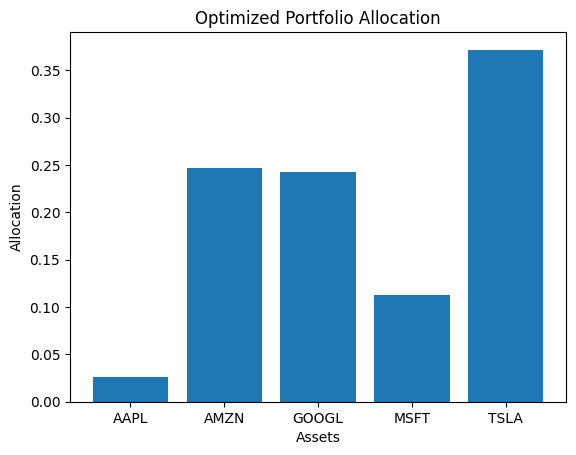

In [13]:
# Step 4: Define Fitness Function
def fitness_function(ga_instance, solution, solution_idx):
    try:
        # Ensure sum of weights equals to 1 (or penalize heavily if not)
        if not np.isclose(np.sum(solution), 1):
            return -np.inf  # Penalize invalid solutions

        # Limit individual asset allocation to a max of 50% to encourage diversity
        if np.any(solution > 0.5):
            return -np.inf  # Penalize solutions that allocate more than 50% to a single asset

        # Calculate portfolio return using predicted returns
        portfolio_return = np.sum(solution * predicted_returns)

        # Calculate portfolio variance
        portfolio_variance = np.dot(solution.T, np.dot(cov_matrix, solution))
        portfolio_risk = np.sqrt(portfolio_variance)

        # Dynamic risk tolerance based on generation count
        max_risk_threshold = 0.25 + (ga_instance.generations_completed / ga_instance.num_generations) * 0.1

        # Ensure that portfolio risk is within a specific range to balance risk and return
        if portfolio_risk == 0 or portfolio_risk > max_risk_threshold:
            return -np.inf  # Invalid solution or too risky

        # Calculate Sharpe Ratio (assuming risk-free rate of 2%)
        sharpe_ratio = (portfolio_return - 0.02) / portfolio_risk

        # Reward diversification: more assets with non-zero weights is better
        num_nonzero_allocations = np.count_nonzero(solution)
        diversification_reward = num_nonzero_allocations / num_assets

        # Additional penalty for concentration beyond 40%
        concentration_penalty = -np.sum(solution[solution > 0.4])

        # Combine Sharpe Ratio with diversification reward and concentration penalty
        fitness_value = sharpe_ratio + diversification_reward + concentration_penalty

        return fitness_value

    except Exception as e:
        print(f"Error calculating fitness for solution {solution_idx}: {e}")
        return -np.inf  # Penalize any solution that fails

# Step 5: Normalize Solutions
def normalize_solution(solution):
    total = np.sum(solution)
    if total == 0:
        # Assign equal weight to all assets if the total is zero
        return np.full_like(solution, 1.0 / len(solution))
    return solution / total

# Step 6: Set Up GA with Early Stopping
best_fitness_values = []

# Update Early Stopping with Higher Sensitivity and Larger Window
def normalize_population(ga_instance):
    global best_fitness_values

    for i in range(ga_instance.sol_per_pop):
        ga_instance.population[i] = normalize_solution(ga_instance.population[i])

    best_fitness = ga_instance.best_solution()[1]
    best_fitness_values.append(best_fitness)

    # Early stopping: check if the fitness value has plateaued
    if len(best_fitness_values) > 30:  # Increased window size
        recent_fitness = best_fitness_values[-30:]
        if np.std(recent_fitness) < 1e-6:  # Increased sensitivity
            ga_instance.stop()  # Stop the evolution if no significant improvement

    # Adaptive mutation: adjust mutation rate based on convergence
    diversity = np.mean([np.std(ind) for ind in ga_instance.population])
    try:
        mutation_percent_genes = float(ga_instance.mutation_percent_genes)
    except ValueError:
        mutation_percent_genes = 10  # Set a default value if conversion fails

    if diversity < 0.1:
        ga_instance.mutation_percent_genes = min(100, mutation_percent_genes + 5)
    else:
        ga_instance.mutation_percent_genes = max(5, mutation_percent_genes - 5)

    print(f"Generation {ga_instance.generations_completed} completed with best fitness: {best_fitness}")

# Step 7: Set Up GA Instance
ga_instance = pygad.GA(num_generations=300,  # Increased number of generations for further exploration
                       num_parents_mating=20,
                       fitness_func=fitness_function,
                       sol_per_pop=100,  # Increased population size for more diversity
                       num_genes=num_assets,
                       init_range_low=0,
                       init_range_high=1,
                       parent_selection_type="tournament",
                       crossover_type="uniform",  # Changed to uniform crossover
                       crossover_probability=0.8,  # Adjusted crossover rate
                       mutation_type="random",
                       mutation_num_genes=3,  # Increase mutation for more exploration
                       gene_space=[{'low': 0, 'high': 1} for _ in range(num_assets)],
                       on_generation=normalize_population)

# Step 8: Run GA
ga_instance.run()

# Step 9: Output the Best Solution
try:
    solution, solution_fitness, _ = ga_instance.best_solution()
    print(f"Best Portfolio: {solution}")
    print(f"Fitness (Sharpe Ratio + Diversification Reward): {solution_fitness}")

    # Visualization: Display allocation
    plt.bar(range(num_assets), solution)
    plt.xlabel("Assets")
    plt.ylabel("Allocation")
    plt.title("Optimized Portfolio Allocation")
    plt.xticks(ticks=range(num_assets), labels=tickers)
    plt.show()

except Exception as e:
    print(f"Error finding the best solution: {e}")


## pygad fitness fucntion

[*********************100%***********************]  5 of 5 completed


Predicted Returns: [0.00334299 0.00291087 0.00316991 0.00173484 0.00567638]
Generation 1 completed with best fitness: 0.34999111452779774
Generation 2 completed with best fitness: 0.3347935128186288
Generation 3 completed with best fitness: 0.37161188455499183
Generation 4 completed with best fitness: 0.35041585815587895
Generation 5 completed with best fitness: 0.3505870350258605
Generation 6 completed with best fitness: 0.3576012065500257
Generation 7 completed with best fitness: 0.3012525206870472
Generation 8 completed with best fitness: 0.31716533209313924
Generation 9 completed with best fitness: 0.358346112967323
Generation 10 completed with best fitness: 0.2997025763046389
Generation 11 completed with best fitness: 0.36935908458437006
Generation 12 completed with best fitness: 0.3527988559039287
Generation 13 completed with best fitness: 0.36193314254035713
Generation 14 completed with best fitness: 0.3728525988114846
Generation 15 completed with best fitness: 0.346241783925980

/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/Computational Intelligence/CW/portfolio_optimization_in_finance/.venv/lib/python3.8/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation 17 completed with best fitness: 0.33962461906041896
Generation 18 completed with best fitness: 0.3475161912661764
Generation 19 completed with best fitness: 0.34388036535636757
Generation 20 completed with best fitness: 0.3492661854403756
Generation 21 completed with best fitness: 0.34364783573762725
Generation 22 completed with best fitness: 0.33362963955630465
Generation 23 completed with best fitness: 0.3565479833779259
Generation 24 completed with best fitness: 0.3354167177756697
Generation 25 completed with best fitness: 0.3654164104496903
Generation 26 completed with best fitness: 0.34669852401490564
Generation 27 completed with best fitness: 0.3063309207633741
Generation 28 completed with best fitness: 0.35513316222649605
Generation 29 completed with best fitness: 0.35827118431332805
Generation 30 completed with best fitness: 0.36703160035281157
Generation 31 completed with best fitness: 0.3445597228562052
Generation 32 completed with best fitness: 0.3648556438845484


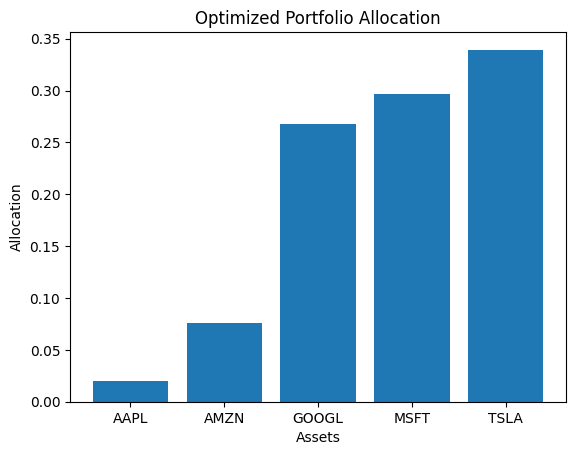

In [49]:
import numpy as np
import pygad
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Step 1: Data Preparation
# Fetch real historical data from Yahoo Finance
num_assets = 5
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Download the adjusted closing prices for the selected tickers
data = yf.download(tickers, start="2020-01-01", end="2024-01-01")['Adj Close']

# Drop tickers that failed to download
data = data.dropna(axis=1, how='all')

# Update the number of assets to reflect actual data downloaded
num_assets = data.shape[1]
tickers = data.columns.tolist()

# Calculate the returns for ML prediction
data_returns = data.pct_change().dropna()

# Step 2: Machine Learning - Predict Expected Returns
# Prepare data for ML model
X = []
y = []
window_size = 30  # Use past 30 days to predict the next day return

for i in range(window_size, len(data_returns) - 1):
    X.append(data_returns.iloc[i - window_size:i].values.flatten())
    y.append(data_returns.iloc[i + 1].values)

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor model to predict returns
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict returns for the latest available data
predicted_returns = model.predict([data_returns.iloc[-window_size:].values.flatten()])[0]
print(f"Predicted Returns: {predicted_returns}")

# Step 3: Define Fitness Function
def fitness_function(ga_instance, solution, solution_idx):
    try:
        # Ensure sum of weights equals to 1 (or penalize heavily if not)
        if not np.isclose(np.sum(solution), 1):
            return -np.inf  # Penalize invalid solutions

        # Limit individual asset allocation to a max of 50% to encourage diversity
        if np.any(solution > 0.5):
            return -np.inf  # Penalize solutions that allocate more than 50% to a single asset

        # Calculate portfolio return using predicted returns
        portfolio_return = np.sum(solution * predicted_returns)

        # Calculate portfolio variance using covariance matrix
        cov_matrix = data_returns.cov().values
        portfolio_variance = np.dot(solution.T, np.dot(cov_matrix, solution))
        portfolio_risk = np.sqrt(portfolio_variance)

        # Dynamic risk tolerance based on generation count
        max_risk_threshold = 0.25 + (ga_instance.generations_completed / ga_instance.num_generations) * 0.1

        # Ensure that portfolio risk is within a specific range to balance risk and return
        if portfolio_risk == 0 or portfolio_risk > max_risk_threshold:
            return -np.inf  # Invalid solution or too risky

        # Calculate Sharpe Ratio (assuming risk-free rate of 2%)
        sharpe_ratio = (portfolio_return - 0.02) / portfolio_risk

        # Reward diversification: more assets with non-zero weights is better
        num_nonzero_allocations = np.count_nonzero(solution)
        diversification_reward = num_nonzero_allocations / num_assets

        # Additional penalty for concentration beyond 40%
        concentration_penalty = -np.sum(solution[solution > 0.4])

        # Combine Sharpe Ratio with diversification reward and concentration penalty
        fitness_value = sharpe_ratio + diversification_reward + concentration_penalty

        return fitness_value

    except Exception as e:
        print(f"Error calculating fitness for solution {solution_idx}: {e}")
        return -np.inf  # Penalize any solution that fails

# Step 4: Normalize Solutions
def normalize_solution(solution):
    total = np.sum(solution)
    if total == 0:
        # Assign equal weight to all assets if the total is zero
        return np.full_like(solution, 1.0 / len(solution))
    return solution / total

# Step 5: Set Up GA with Early Stopping
best_fitness_values = []

# Update Early Stopping with Higher Sensitivity and Larger Window
def normalize_population(ga_instance):
    global best_fitness_values

    for i in range(ga_instance.sol_per_pop):
        ga_instance.population[i] = normalize_solution(ga_instance.population[i])

    best_fitness = ga_instance.best_solution()[1]
    best_fitness_values.append(best_fitness)

    # Early stopping: check if the fitness value has plateaued
    if len(best_fitness_values) > 30:  # Increased window size
        recent_fitness = best_fitness_values[-30:]
        if np.std(recent_fitness) < 1e-6:  # Increased sensitivity
            ga_instance.stop()  # Stop the evolution if no significant improvement

    # Adaptive mutation: adjust mutation rate based on convergence
    diversity = np.mean([np.std(ind) for ind in ga_instance.population])
    try:
        mutation_percent_genes = float(ga_instance.mutation_percent_genes)
    except ValueError:
        mutation_percent_genes = 10  # Set a default value if conversion fails

    if diversity < 0.1:
        ga_instance.mutation_percent_genes = min(100, mutation_percent_genes + 5)
    else:
        ga_instance.mutation_percent_genes = max(5, mutation_percent_genes - 5)

    print(f"Generation {ga_instance.generations_completed} completed with best fitness: {best_fitness}")

# Step 6: Increase population size, number of generations, and modify crossover strategy for better exploration
ga_instance = pygad.GA(num_generations=300,  # Increased number of generations for further exploration
                       num_parents_mating=20,
                       fitness_func=fitness_function,
                       sol_per_pop=100,  # Increased population size for more diversity
                       num_genes=num_assets,
                       init_range_low=0,
                       init_range_high=1,
                       parent_selection_type="tournament",
                       crossover_type="uniform",  # Changed to uniform crossover
                       crossover_probability=0.8,  # Adjusted crossover rate
                       mutation_type="random",
                       mutation_num_genes=3,  # Increase mutation for more exploration
                       gene_space=[{'low': 0, 'high': 1} for _ in range(num_assets)],
                       on_generation=normalize_population)

# Step 7: Run GA
ga_instance.run()

# Step 8: Output the Best Solution
try:
    solution, solution_fitness, _ = ga_instance.best_solution()
    print(f"Best Portfolio: {solution}")
    print(f"Fitness (Sharpe Ratio + Diversification Reward): {solution_fitness}")

    # Visualization: Display allocation
    plt.bar(range(num_assets), solution)
    plt.xlabel("Assets")
    plt.ylabel("Allocation")
    plt.title("Optimized Portfolio Allocation")
    plt.xticks(ticks=range(num_assets), labels=tickers)
    plt.show()

except Exception as e:
    print(f"Error finding the best solution: {e}")

    


[*********************100%***********************]  5 of 5 completed


Predicted Returns: [0.00334299 0.00291087 0.00316991 0.00173484 0.00567638]
Generation 1 completed with best fitness: 1.833088474856135
Generation 2 completed with best fitness: 1.7411463208748579
Generation 3 completed with best fitness: 1.7600222672831682
Generation 4 completed with best fitness: 1.8555160442368113
Generation 5 completed with best fitness: 1.7172307864588716
Generation 6 completed with best fitness: 1.740600448016083
Generation 7 completed with best fitness: 1.844466943725393
Generation 8 completed with best fitness: 1.5332905723502666
Generation 9 completed with best fitness: 0.970929891796416
Generation 10 completed with best fitness: 1.585969870312149
Generation 11 completed with best fitness: 1.4093707293530806
Generation 12 completed with best fitness: 1.5897979226917824
Generation 13 completed with best fitness: 1.8933780076965079
Generation 14 completed with best fitness: 1.6694542922141258
Generation 15 completed with best fitness: 1.4882447605551894
Generati

/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/Computational Intelligence/CW/portfolio_optimization_in_finance/.venv/lib/python3.8/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation 43 completed with best fitness: 1.4649433074659604
Generation 44 completed with best fitness: 1.8209498150504264
Generation 45 completed with best fitness: 1.6772830677912784
Generation 46 completed with best fitness: 1.6837773281124297
Generation 47 completed with best fitness: 1.6699383203989742
Generation 48 completed with best fitness: 1.6699383203989742
Generation 49 completed with best fitness: 1.6699383203989742
Generation 50 completed with best fitness: 1.6699383203989742
Generation 51 completed with best fitness: 1.6699383203989742
Generation 52 completed with best fitness: 1.9500610909534304
Generation 53 completed with best fitness: 1.9500610909534313
Generation 54 completed with best fitness: 1.9500610909534313
Generation 55 completed with best fitness: 1.9843998715719613
Generation 56 completed with best fitness: 1.9500610909534313
Generation 57 completed with best fitness: 1.9500610909534313
Generation 58 completed with best fitness: 1.9500610909534313
Generati

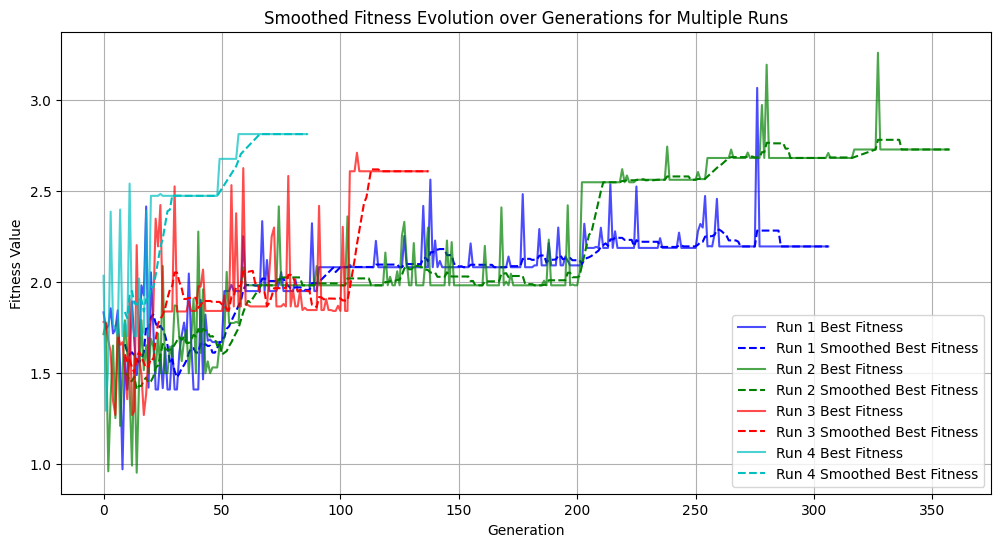

Run 1 Best Portfolio: [0.01652527 0.5357854  0.36519488 0.08249445 0.        ]
Run 1 Fitness (Sharpe Ratio + Diversification Reward): 3.0665265978514364
Run 1 Stopped at Generation: 307

Run 2 Best Portfolio: [0.         0.         0.30069669 0.66884976 0.03045356]
Run 2 Fitness (Sharpe Ratio + Diversification Reward): 3.2595597760245045
Run 2 Stopped at Generation: 358

Run 3 Best Portfolio: [0.11698204 0.35556074 0.31103853 0.20756902 0.00884967]
Run 3 Fitness (Sharpe Ratio + Diversification Reward): 2.7101137173923773
Run 3 Stopped at Generation: 138

Run 4 Best Portfolio: [0.22302615 0.07590007 0.21514999 0.24485794 0.24106585]
Run 4 Fitness (Sharpe Ratio + Diversification Reward): 2.8125070897019144
Run 4 Stopped at Generation: 87



In [136]:
import numpy as np
import pygad
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: Data Preparation
# Fetch real historical data from Yahoo Finance
num_assets = 5
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Download the adjusted closing prices for the selected tickers
data = yf.download(tickers, start="2020-01-01", end="2024-01-01")['Adj Close']

# Drop tickers that failed to download
data = data.dropna(axis=1, how='all')

# Update the number of assets to reflect actual data downloaded
num_assets = data.shape[1]
tickers = data.columns.tolist()

# Calculate the returns for ML prediction
data_returns = data.pct_change().dropna()

# Step 2: Machine Learning - Predict Expected Returns
# Prepare data for ML model
X = []
y = []
window_size = 30  # Use past 30 days to predict the next day return

for i in range(window_size, len(data_returns) - 1):
    X.append(data_returns.iloc[i - window_size:i].values.flatten())
    y.append(data_returns.iloc[i + 1].values)

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor model to predict returns
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict returns for the latest available data
predicted_returns = model.predict([data_returns.iloc[-window_size:].values.flatten()])[0]
print(f"Predicted Returns: {predicted_returns}")

# Step 3: Define Fitness Function (with balancing adjustment)
def fitness_function(ga_instance, solution, solution_idx):
    try:
        # Ensure sum of weights approximately equals 1
        if not 0.98 <= np.sum(solution) <= 1.02:
            penalty = abs(np.sum(solution) - 1) * 10  # Penalize solutions that deviate too much
            return -penalty

        # Ensure minimum allocation constraint
        if np.any(solution < 0.05):
            penalty = -np.sum(solution[solution < 0.05]) * 20  # Stronger penalty for solutions with less than 5% allocation to any asset
            return -penalty

        # Calculate portfolio return using predicted returns
        portfolio_return = np.sum(solution * predicted_returns)

        # Calculate portfolio variance using covariance matrix
        cov_matrix = data_returns.cov().values
        portfolio_variance = np.dot(solution.T, np.dot(cov_matrix, solution))
        portfolio_risk = np.sqrt(portfolio_variance)

        # Risk Threshold
        max_risk_threshold = 0.35
        if portfolio_risk > max_risk_threshold:
            penalty = (portfolio_risk - max_risk_threshold) * 10
            return -penalty

        # Calculate Sharpe Ratio (assuming risk-free rate of 2%)
        sharpe_ratio = (portfolio_return - 0.02) / portfolio_risk

        # Reward diversification: encourage more assets to have non-zero allocations
        num_nonzero_allocations = np.count_nonzero(solution)
        diversification_reward = num_nonzero_allocations / num_assets

        # Penalty for large variance in allocation (encourage balanced weights)
        variance_penalty = np.var(solution) * 5  # Tuned factor to control emphasis on balanced allocations

        # Encourage balance by adding a reward for solutions that have more even distribution among assets
        allocation_balance_reward = -np.std(solution)  # Reward lower standard deviation in allocations

        # Calculate fitness by combining different components
        fitness_value = sharpe_ratio + diversification_reward - variance_penalty + allocation_balance_reward

        # Clip fitness values to avoid very small values
        fitness_value = max(fitness_value, 1e-6)

        return fitness_value

    except Exception as e:
        print(f"Error calculating fitness for solution {solution_idx}: {e}")
        return -10  # Penalize any solution that fails


# Step 4: Normalize Solutions
def normalize_solution(solution):
    total = np.sum(solution)
    if total == 0:
        return np.full_like(solution, 1.0 / len(solution))
    return solution / total


# Step 5: Set Up GA with Early Stopping and Multiple Runs
num_runs = 4  # Number of GA runs to plot different curves
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Colors for each run

# Lists to store best fitness evolution, solutions, and early stopping generations from all runs
all_best_fitness_values = []
all_best_solutions = []
all_best_fitness_overall = []
early_stopping_generations = []

for run in range(num_runs):
    best_fitness_values = []
    average_fitness_values = []
    best_solution_overall = None
    best_solution_fitness = -np.inf

    def normalize_population(ga_instance):
        global best_fitness_values, average_fitness_values, best_solution_overall, best_solution_fitness

        # Normalize solutions
        for i in range(ga_instance.sol_per_pop):
            ga_instance.population[i] = normalize_solution(ga_instance.population[i])

        fitness_values = [fitness_function(ga_instance, solution, idx) for idx, solution in enumerate(ga_instance.population)]
        best_fitness = np.max(fitness_values)
        average_fitness = np.mean(fitness_values)

        # Update the best solution overall if the current best is better
        if best_fitness > best_solution_fitness:
            best_solution_overall = ga_instance.population[np.argmax(fitness_values)]
            best_solution_fitness = best_fitness

        best_fitness_values.append(best_fitness)
        average_fitness_values.append(average_fitness)

        # Early stopping if fitness values have plateaued
        if len(best_fitness_values) > 30 and np.std(best_fitness_values[-30:]) < 1e-6:
            early_stopping_generations.append(ga_instance.generations_completed)
            return "stop"

        print(f"Generation {ga_instance.generations_completed} completed with best fitness: {best_fitness}")

    # Set up and run the Genetic Algorithm for each run
    ga_instance = pygad.GA(num_generations=1000,
                           num_parents_mating=30,
                           fitness_func=fitness_function,
                           sol_per_pop=100,
                           num_genes=num_assets,
                           init_range_low=0,
                           init_range_high=1,
                           parent_selection_type="tournament",
                           crossover_type="uniform",  # Switched to uniform crossover
                           crossover_probability=0.8,
                           mutation_type="random",
                           mutation_percent_genes=25,  # Increased mutation rate
                           gene_space=[{'low': 0, 'high': 1} for _ in range(num_assets)],
                           on_generation=normalize_population,
                           keep_elitism=2)

    ga_instance.run()

    # If early stopping didn't happen, record the total number of generations
    if len(early_stopping_generations) < run + 1:
        early_stopping_generations.append(ga_instance.generations_completed)

    # Store the results of the run
    all_best_fitness_values.append(best_fitness_values)
    all_best_solutions.append(best_solution_overall)
    all_best_fitness_overall.append(best_solution_fitness)

# # Visualization of Fitness Evolution across all runs
# plt.figure(figsize=(12, 6))
# for run in range(num_runs):
#     plt.plot(all_best_fitness_values[run], label=f"Run {run + 1}", color=colors[run], linestyle='-', alpha=0.7)

# plt.xlabel("Generation")
# plt.ylabel("Fitness Value")
# plt.title("Fitness Evolution over Generations for Multiple Runs")
# plt.legend()
# plt.grid(True)
# plt.show()

# Step 8: Output the Best Solution Found Overall for Each Run and Early Stopping Generation
plt.figure(figsize=(12, 6))
for run in range(num_runs):
    smoothed_best_fitness = pd.Series(all_best_fitness_values[run]).rolling(window=10).mean()
    plt.plot(all_best_fitness_values[run], color=colors[run], linestyle='-', alpha=0.7, label=f"Run {run + 1} Best Fitness")
    plt.plot(smoothed_best_fitness, color=colors[run], linestyle='--', label=f"Run {run + 1} Smoothed Best Fitness")

plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.title("Smoothed Fitness Evolution over Generations for Multiple Runs")
plt.legend()
plt.grid(True)
plt.show()

for run in range(num_runs):
    print(f"Run {run + 1} Best Portfolio: {all_best_solutions[run]}")
    print(f"Run {run + 1} Fitness (Sharpe Ratio + Diversification Reward): {all_best_fitness_overall[run]}")
    print(f"Run {run + 1} Stopped at Generation: {early_stopping_generations[run]}\n")


## DEAP utilized 

[*********************100%***********************]  5 of 5 completed
/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/Computational Intelligence/CW/portfolio_optimization_in_finance/.venv/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/Computational Intelligence/CW/portfolio_optimization_in_finance/.venv/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: {'avg': -29.826169812060765, 'std': 170.61786816976, 'min': -1000.0, 'max': 0.37254234531963504}
Generation 1 completed with best fitness: 0.37254234531963504
Generation 1: {'avg': 0.2548656987752237, 'std': 0.0993607359491092, 'min': -0.24811896481903373, 'max': 0.37254234531963504}
Generation 2 completed with best fitness: 0.37254234531963504
Generation 2: {'avg': -19.77417881546837, 'std': 140.03233977177223, 'min': -1000.0, 'max': 0.36811801393003285}
Generation 3 completed with best fitness: 0.36811801393003285
Generation 3: {'avg': -9.716878413590578, 'std': 99.52724947842142, 'min': -1000.0, 'max': 0.36811801393003285}
Generation 4 completed with best fitness: 0.36811801393003285
Generation 4: {'avg': -49.76816444949037, 'std': 217.9981928079173, 'min': -1000.0, 'max': 0.36811801393003285}
Generation 5 completed with best fitness: 0.36811801393003285
Generation 5: {'avg': -49.78923746090552, 'std': 217.99337741214276, 'min': -1000.0, 'max': 0.36811801393003285}
Gen

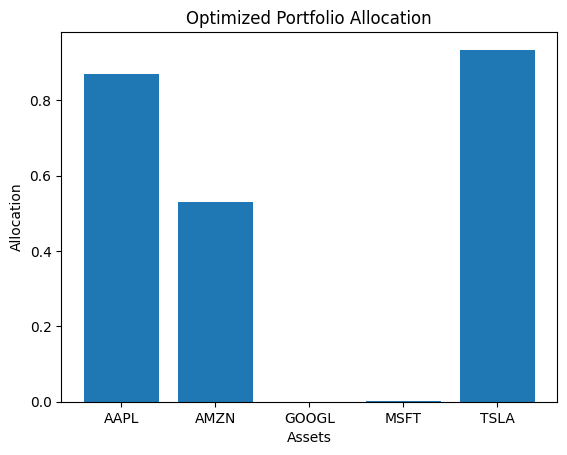

In [57]:
import numpy as np
import random
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from deap import base, creator, tools, algorithms

# Step 1: Data Preparation
# Fetch real historical data from Yahoo Finance
num_assets = 5
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Download the adjusted closing prices for the selected tickers
data = yf.download(tickers, start="2020-01-01", end="2024-01-01")['Adj Close']
data = data.dropna(axis=1, how='all')

# Update the number of assets to reflect actual data downloaded
num_assets = data.shape[1]
tickers = data.columns.tolist()

# Calculate returns
data_returns = data.pct_change().dropna()

# Step 2: Machine Learning - Predict Expected Returns
X = []
y = []
window_size = 30

for i in range(window_size, len(data_returns) - 1):
    X.append(data_returns.iloc[i - window_size:i].values.flatten())
    y.append(data_returns.iloc[i + 1].values)

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predicted_returns = model.predict([data_returns.iloc[-window_size:].values.flatten()])[0]

# Step 3: Define Fitness Function
def fitness_function(individual):
    solution = np.array(individual)
    solution = solution / np.sum(solution)  # Normalize the solution to ensure sum = 1

    if np.any(solution > 0.5):
        return -1000,  # Penalize solutions with any weight > 0.5

    portfolio_return = np.sum(solution * predicted_returns)
    cov_matrix = data_returns.cov().values
    portfolio_variance = np.dot(solution.T, np.dot(cov_matrix, solution))
    portfolio_risk = np.sqrt(portfolio_variance)

    max_risk_threshold = 0.25 + (gen_counter / max_generations) * 0.1

    if portfolio_risk > max_risk_threshold:
        return -500,  # Penalize high-risk solutions

    sharpe_ratio = (portfolio_return - 0.02) / (portfolio_risk + 1e-6)
    num_nonzero_allocations = np.count_nonzero(solution)
    diversification_reward = num_nonzero_allocations / num_assets
    concentration_penalty = -np.sum(solution[solution > 0.4])

    fitness_value = sharpe_ratio + diversification_reward + concentration_penalty
    return fitness_value,

# Step 4: DEAP Genetic Algorithm Setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=num_assets)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=0.5, low=0, up=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", fitness_function)

# Step 5: Run the Genetic Algorithm
population_size = 100
max_generations = 300
gen_counter = 0
population = toolbox.population(n=population_size)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

hall_of_fame = tools.HallOfFame(1)

def custom_callback(population):
    global gen_counter
    gen_counter += 1
    best_ind = tools.selBest(population, 1)[0]
    print(f"Generation {gen_counter} completed with best fitness: {best_ind.fitness.values[0]}")

# Custom Evolution Loop
for gen in range(max_generations):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.8:  # Crossover probability
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:  # Mutation probability
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace the old population with the new population
    population[:] = offspring

    # Update Hall of Fame and statistics
    hall_of_fame.update(population)
    record = stats.compile(population)
    print(f"Generation {gen}: {record}")

    # Custom callback to track generation progress
    custom_callback(population)

# Step 6: Output Best Solution
best_portfolio = hall_of_fame[0]
best_fitness = best_portfolio.fitness.values[0]
print(f"Best Portfolio: {best_portfolio}")
print(f"Fitness (Sharpe Ratio + Diversification Reward): {best_fitness}")

# Visualization
plt.bar(range(num_assets), best_portfolio)
plt.xlabel("Assets")
plt.ylabel("Allocation")
plt.title("Optimized Portfolio Allocation")
plt.xticks(ticks=range(num_assets), labels=tickers)
plt.show()


[*********************100%***********************]  5 of 5 completed
/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/Computational Intelligence/CW/portfolio_optimization_in_finance/.venv/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/Computational Intelligence/CW/portfolio_optimization_in_finance/.venv/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: {'avg': -19.922625749399884, 'std': 140.01118078485248, 'min': -1000.0, 'max': 0.36469695011330916}
Generation 1: {'avg': -39.831289272973216, 'std': 195.9936826471303, 'min': -1000.0, 'max': 0.36469695011330916}
Generation 2: {'avg': -9.785866344428191, 'std': 99.52036125352144, 'min': -1000.0, 'max': 0.36469695011330916}
Generation 3: {'avg': -39.77477310000847, 'std': 196.00520902070872, 'min': -1000.0, 'max': 0.37062555989080215}
Generation 4: {'avg': -9.741062835133523, 'std': 99.52490089442244, 'min': -1000.0, 'max': 0.3758659560421921}
Generation 5: {'avg': -59.76278584009365, 'std': 237.54682737089777, 'min': -1000.0, 'max': 0.37633454766951946}
Generation 6: {'avg': -59.73404712851626, 'std': 237.55407280696124, 'min': -1000.0, 'max': 0.37633454766951946}
Generation 7: {'avg': -29.74878551147296, 'std': 170.63147239494887, 'min': -1000.0, 'max': 0.37633454766951946}
Generation 8: {'avg': -9.726896965884292, 'std': 99.52630716079271, 'min': -1000.0, 'max': 0.37742

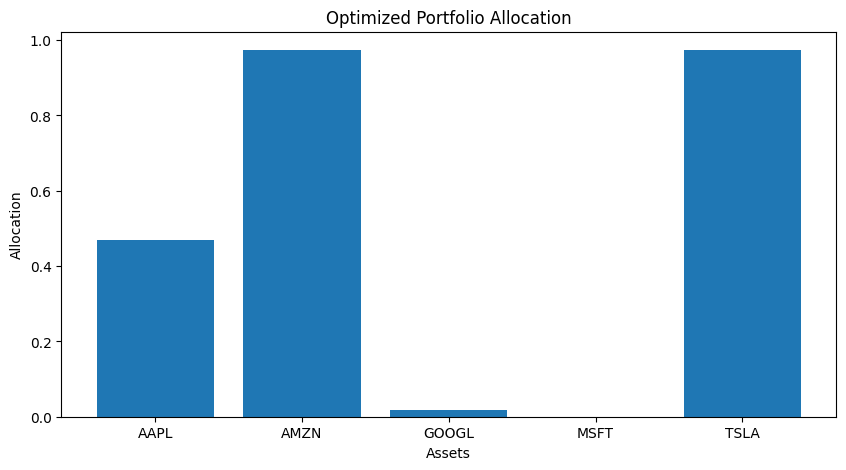

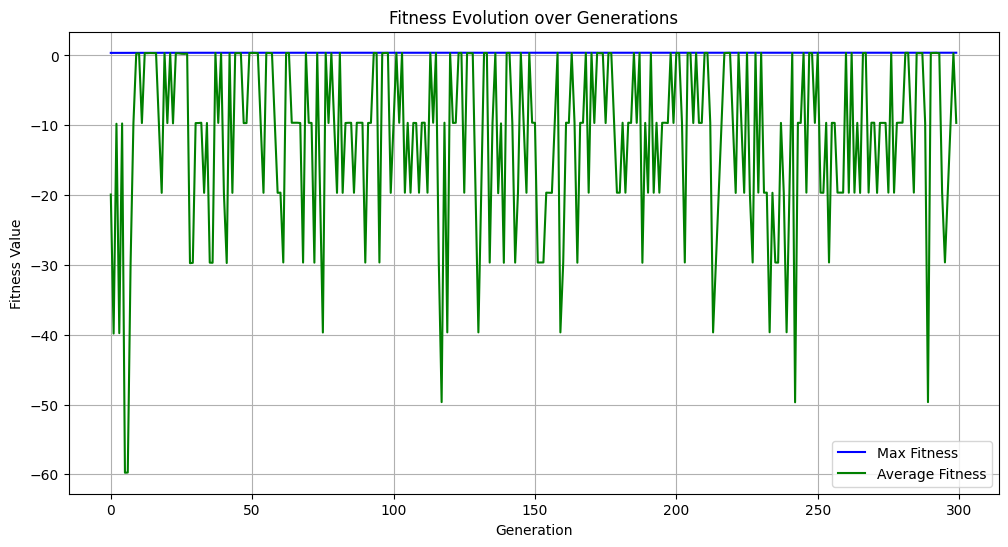

In [58]:
import numpy as np
import random
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from deap import base, creator, tools, algorithms

# Step 1: Data Preparation
# Fetch real historical data from Yahoo Finance
num_assets = 5
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Download the adjusted closing prices for the selected tickers
data = yf.download(tickers, start="2020-01-01", end="2024-01-01")['Adj Close']
data = data.dropna(axis=1, how='all')

# Update the number of assets to reflect actual data downloaded
num_assets = data.shape[1]
tickers = data.columns.tolist()

# Calculate returns
data_returns = data.pct_change().dropna()

# Step 2: Machine Learning - Predict Expected Returns
X = []
y = []
window_size = 30

for i in range(window_size, len(data_returns) - 1):
    X.append(data_returns.iloc[i - window_size:i].values.flatten())
    y.append(data_returns.iloc[i + 1].values)

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predicted_returns = model.predict([data_returns.iloc[-window_size:].values.flatten()])[0]

# Step 3: Define Fitness Function
def fitness_function(individual):
    solution = np.array(individual)
    solution = solution / np.sum(solution)  # Normalize the solution to ensure sum = 1

    if np.any(solution > 0.5):
        return -1000,  # Penalize solutions with any weight > 0.5

    portfolio_return = np.sum(solution * predicted_returns)
    cov_matrix = data_returns.cov().values
    portfolio_variance = np.dot(solution.T, np.dot(cov_matrix, solution))
    portfolio_risk = np.sqrt(portfolio_variance)

    max_risk_threshold = 0.25 + (gen_counter / max_generations) * 0.1

    if portfolio_risk > max_risk_threshold:
        return -500,  # Penalize high-risk solutions

    sharpe_ratio = (portfolio_return - 0.02) / (portfolio_risk + 1e-6)
    num_nonzero_allocations = np.count_nonzero(solution)
    diversification_reward = num_nonzero_allocations / num_assets
    concentration_penalty = -np.sum(solution[solution > 0.4])

    fitness_value = sharpe_ratio + diversification_reward + concentration_penalty
    return fitness_value,

# Step 4: DEAP Genetic Algorithm Setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=num_assets)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=0.5, low=0, up=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", fitness_function)

# Step 5: Run the Genetic Algorithm
population_size = 100
max_generations = 300
gen_counter = 0
population = toolbox.population(n=population_size)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

hall_of_fame = tools.HallOfFame(1)

# Track fitness evolution
generations = []
fitness_max = []
fitness_avg = []

# Custom Evolution Loop
for gen in range(max_generations):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.8:  # Crossover probability
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:  # Mutation probability
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace the old population with the new population
    population[:] = offspring

    # Update Hall of Fame and statistics
    hall_of_fame.update(population)
    record = stats.compile(population)
    print(f"Generation {gen}: {record}")

    # Track fitness statistics
    generations.append(gen)
    fitness_max.append(record['max'])
    fitness_avg.append(record['avg'])

# Step 6: Output Best Solution
best_portfolio = hall_of_fame[0]
best_fitness = best_portfolio.fitness.values[0]
print(f"Best Portfolio: {best_portfolio}")
print(f"Fitness (Sharpe Ratio + Diversification Reward): {best_fitness}")

# Visualization: Best Portfolio Allocation
plt.figure(figsize=(10, 5))
plt.bar(range(num_assets), best_portfolio)
plt.xlabel("Assets")
plt.ylabel("Allocation")
plt.title("Optimized Portfolio Allocation")
plt.xticks(ticks=range(num_assets), labels=tickers)
plt.show()

# Visualization: Fitness Evolution
plt.figure(figsize=(12, 6))
plt.plot(generations, fitness_max, label="Max Fitness", color='b')
plt.plot(generations, fitness_avg, label="Average Fitness", color='g')
plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.title("Fitness Evolution over Generations")
plt.legend()
plt.grid(True)
plt.show()

## LSTM

[*********************100%***********************]  5 of 5 completed


Epoch 1/100
37/37 [==============================] - 2s 15ms/step - loss: 6.7571e-04 - val_loss: 6.3150e-04
Epoch 2/100
37/37 [==============================] - 0s 11ms/step - loss: 6.7489e-04 - val_loss: 6.3346e-04
Epoch 3/100
37/37 [==============================] - 1s 18ms/step - loss: 6.7486e-04 - val_loss: 6.3293e-04
Epoch 4/100
37/37 [==============================] - 0s 13ms/step - loss: 6.7484e-04 - val_loss: 6.3296e-04
Epoch 5/100
37/37 [==============================] - 0s 13ms/step - loss: 6.7442e-04 - val_loss: 6.3259e-04
Epoch 6/100
37/37 [==============================] - 0s 13ms/step - loss: 6.7476e-04 - val_loss: 6.3317e-04
Epoch 7/100
37/37 [==============================] - 0s 14ms/step - loss: 6.7499e-04 - val_loss: 6.3262e-04
Epoch 8/100
37/37 [==============================] - 0s 13ms/step - loss: 6.7509e-04 - val_loss: 6.3458e-04
Epoch 9/100
37/37 [==============================] - 1s 14ms/step - loss: 6.7485e-04 - val_loss: 6.3213e-04
Epoch 10/100
37/37 [========

/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/Computational Intelligence/CW/portfolio_optimization_in_finance/.venv/lib/python3.8/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation 23 completed with best fitness: -15.721976634689474
Generation 24 completed with best fitness: -15.725108484732042
Generation 25 completed with best fitness: -15.769355404365983
Generation 26 completed with best fitness: -16.493791982098085
Generation 27 completed with best fitness: -16.042445608840335
Generation 28 completed with best fitness: -16.648411562348358
Generation 29 completed with best fitness: -15.773629740943825
Generation 30 completed with best fitness: -15.745824518366968
Generation 31 completed with best fitness: -16.25776820455519
Generation 32 completed with best fitness: -15.662533425000857
Generation 33 completed with best fitness: -15.695480379675951
Generation 34 completed with best fitness: -15.789308618197415
Generation 35 completed with best fitness: -15.60059753180426
Generation 36 completed with best fitness: -15.625665767334539
Generation 37 completed with best fitness: -15.558973761292247
Generation 38 completed with best fitness: -15.6858920499

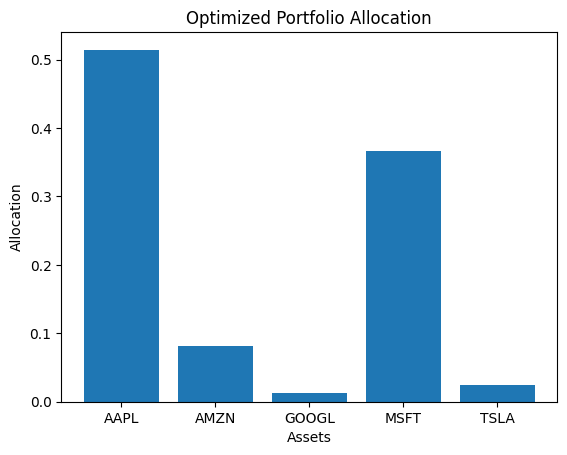

In [ ]:
import numpy as np
import pygad
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 1: Data Preparation
# Fetch real historical data from Yahoo Finance
num_assets = 5
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Download the adjusted closing prices for the selected tickers
data = yf.download(tickers, start="2018-01-01", end="2024-01-01")['Adj Close']

# Drop tickers that failed to download
data = data.dropna(axis=1, how='all')

# Update the number of assets to reflect actual data downloaded
num_assets = data.shape[1]
tickers = data.columns.tolist()

# Calculate the returns for ML prediction
data_returns = data.pct_change().dropna()

# Step 2: Machine Learning - Predict Expected Returns with LSTM
window_size = 30  # Use past 30 days to predict the next day return
forecast_horizon = 30  # Predict the next 30 days of returns

# Prepare the data for LSTM
X = []
y = []

for i in range(window_size, len(data_returns) - forecast_horizon):
    X.append(data_returns.iloc[i - window_size:i].values)
    y.append(data_returns.iloc[i:i + forecast_horizon].values)

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM Model Definition
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=num_assets * forecast_horizon))  # Predict returns for each asset over the forecast horizon
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train, y_train.reshape(y_train.shape[0], -1), epochs=100, batch_size=32, validation_data=(X_test, y_test.reshape(y_test.shape[0], -1)))

# Predict returns for the latest available data
latest_data = data_returns.iloc[-window_size:].values.reshape(1, window_size, num_assets)
predicted_returns = model.predict(latest_data)
predicted_returns = predicted_returns.reshape(forecast_horizon, num_assets)

print(f"Predicted Returns for {forecast_horizon} Days:\n{predicted_returns}")

# Step 3: Define Fitness Function for GA
def fitness_function(ga_instance, solution, solution_idx):
    try:
        # Ensure sum of weights equals 1 (or penalize heavily if not)
        if not np.isclose(np.sum(solution), 1):
            return -np.inf  # Penalize invalid solutions

        # Penalize negative allocations (no short selling allowed)
        if np.any(solution < 0):
            return -np.inf  # Penalize any negative allocation

        # Calculate portfolio return over forecast horizon using predicted returns
        portfolio_return = np.sum(solution * np.mean(predicted_returns, axis=0))

        # Calculate portfolio variance using covariance matrix of predicted returns
        cov_matrix = np.cov(predicted_returns.T)
        portfolio_variance = np.dot(solution.T, np.dot(cov_matrix, solution))
        portfolio_risk = np.sqrt(portfolio_variance)

        # Dynamic risk tolerance based on generation count
        max_risk_threshold = 0.35  # Increased the risk threshold

        # Ensure that portfolio risk is within a specific range to balance risk and return
        if portfolio_risk == 0 or portfolio_risk > max_risk_threshold:
            return -np.inf  # Invalid solution or too risky

        # Calculate Sharpe Ratio (assuming risk-free rate of 2%)
        sharpe_ratio = (portfolio_return - 0.02) / portfolio_risk

        # Reward diversification: more assets with non-zero weights is better
        num_nonzero_allocations = np.count_nonzero(solution)
        diversification_reward = num_nonzero_allocations / num_assets

        # Additional penalty for concentration beyond 60%
        concentration_penalty = -np.sum(solution[solution > 0.6])

        # Combine Sharpe Ratio with diversification reward and concentration penalty
        fitness_value = sharpe_ratio + diversification_reward + concentration_penalty

        return fitness_value

    except Exception as e:
        print(f"Error calculating fitness for solution {solution_idx}: {e}")
        return -np.inf  # Penalize any solution that fails

# Step 4: Set Up GA with Early Stopping
best_fitness_values = []

def normalize_population(ga_instance):
    global best_fitness_values

    for i in range(ga_instance.sol_per_pop):
        ga_instance.population[i] = normalize_solution(ga_instance.population[i])

    best_fitness = ga_instance.best_solution()[1]
    best_fitness_values.append(best_fitness)

    # Adaptive mutation rate
    diversity = np.mean([np.std(ind) for ind in ga_instance.population])
    mutation_percent_genes = float(ga_instance.mutation_percent_genes) if not isinstance(ga_instance.mutation_percent_genes, str) else 10

    if diversity < 0.1:
        ga_instance.mutation_percent_genes = min(100, mutation_percent_genes + 5)
    else:
        ga_instance.mutation_percent_genes = max(5, mutation_percent_genes - 5)

    print(f"Generation {ga_instance.generations_completed} completed with best fitness: {best_fitness}")

# Step 5: Run Genetic Algorithm
ga_instance = pygad.GA(num_generations=300,
                       num_parents_mating=20,
                       fitness_func=fitness_function,
                       sol_per_pop=100,
                       num_genes=num_assets,
                       init_range_low=0,
                       init_range_high=1,
                       parent_selection_type="tournament",
                       crossover_type="uniform",
                       crossover_probability=0.8,
                       mutation_type="random",
                       mutation_num_genes=3,
                       gene_space=[{'low': 0, 'high': 1} for _ in range(num_assets)],
                       on_generation=normalize_population)

# Run GA
ga_instance.run()

# Output the Best Solution
try:
    solution, solution_fitness, _ = ga_instance.best_solution()
    print(f"Best Portfolio: {solution}")
    print(f"Fitness (Sharpe Ratio + Diversification Reward): {solution_fitness}")

    # Visualization: Display allocation
    plt.bar(range(num_assets), solution)
    plt.xlabel("Assets")
    plt.ylabel("Allocation")
    plt.title("Optimized Portfolio Allocation")
    plt.xticks(ticks=range(num_assets), labels=tickers)
    plt.show()

except Exception as e:
    print(f"Error finding the best solution: {e}")
